In [1]:
import os
os.chdir('/home/express-v2')
import datatools.pitch_control as pc
from matplotlib.colors import TwoSlopeNorm
params = pc.default_model_params()

/home/express-v2


In [2]:
# Generate Pitch Control for predictor models
def calculate_model_pitch_control(results_df, event_id):
    event_df = results_df[results_df["event_id"] == event_id].copy()
    print(event_df)
    # event_df["x"] = event_df["act_x"].copy()
    # event_df["y"] = event_df["act_y"].copy()


    # event_df.loc[event_df["team_on_ball"] == False, "x"] = config.field_length - event_df.loc[event_df["team_on_ball"] == False, "x"].values
    # event_df.loc[event_df["team_on_ball"] == False, "y"] = config.field_width - event_df.loc[event_df["team_on_ball"] == False, "y"].values
    print(event_df.iloc[0], event_df)
    PPCFa, xgrid, ygrid = pc.generate_pitch_control_for_event(
        event_df.iloc[0], event_df, params, 
        field_dimen=(105, 68,), 
        n_grid_cells_x=52, n_grid_cells_y=34, offsides=False, #52.2
    )
    
    fig, ax = pc.plot_pitchcontrol_for_event(PPCFa, event_df.iloc[0], event_df)
    fig.set_size_inches(12,8)

    return PPCFa, ax, event_df, xgrid, ygrid

def plot_pitchcontrol(event_id, PPCF, locs, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (105.0, 68)):
    #highlight = events[events["event_id"] == event_id].iloc[0]

    if False:
        cond = (locs["period_id"] == 1)
        locs.loc[cond, "x"] = (
            105 - locs.loc[cond, "x"].values
        )
        locs.loc[cond, "y"] = (
            68 - locs.loc[cond, "y"].values
        )
    
    row = {}
    for r in locs.itertuples():
        row[f"{r.key}_x"] = r.x
        row[f"{r.key}_y"] = r.y
    # row["B00_x"] = locs.iloc[0].ballx
    # row["B00_y"] = locs.iloc[0].bally
    trace = pd.DataFrame.from_dict(row, orient='index').T


    # 컬러바 생성
    # cbar = fig.colorbar(pc, orientation='vertical')
    # cbar.set_label('Probability')
    
    norm = TwoSlopeNorm(vmin=0.0, vcenter=0.5, vmax=np.max(PPCF))
    # pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]),
    #             norm=norm, cmap='bwr', alpha=0.5)

    pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]), 
                vmin=0.0, vmax=1.0, cmap='bwr', alpha=0.5)
    
    # for i in range(PPCF.shape[0]):
    #     for j in range(PPCF.shape[1]):
    #         val = PPCF[i, j]
    #         if val > 0.01:  # 너무 작은 값은 생략
    #             ax.text(
    #                 j * (field_dimen[0] / PPCF.shape[1]) + (field_dimen[0] / (2 * PPCF.shape[1])),  # x
    #                 i * (field_dimen[1] / PPCF.shape[0]) + (field_dimen[1] / (2 * PPCF.shape[0])),  # y
    #                 f"{val:.2f}",
    #                 color='black',
    #                 ha='center',
    #                 va='center',
    #                 fontsize=6,
    #                 alpha=0.8
    #             )
    norm = TwoSlopeNorm(vmin=0.0, vcenter=0.5, vmax=1.0)

    # pc = ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]),cmap='bwr',alpha=0.5, norm=norm)
    # cbar = fig.colorbar(pc, orientation='vertical')
    # cbar.set_label('Probability')

    return fig, ax

In [6]:
def flatten_df(merged_df):  
    # 1. ball 위치를 따로 추출
    ball_df = merged_df[merged_df['id'] == 'ball'][['frame_id', 'x', 'y']].rename(columns={'x': 'ballx', 'y': 'bally'})

    # 2. 공 소유 선수를 제외한 나머지 행들만 필터링 (또는 모든 행을 쓸 수 있음)
    player_df = merged_df[merged_df['id'] != 'ball'].copy()

    # 3. 각 선수의 위치 정보에 해당 프레임의 공 위치 병합
    melted = pd.merge(player_df, ball_df, on='frame_id', how='left')

    # 4. 필요한 컬럼만 추려내기 
    melted = melted[[
        'player_code',
        'period_id',
        'frame_id',
        'team_id',
        'ball_owning_team_id',
        'is_ball_carrier',
        'position_name',
        'x', 'y', 'vx', 'vy',
        'ballx', 'bally'
    ]].rename(columns={
        'frame_id': 'event_id',
        'player_code': 'key',
        'is_ball_carrier': 'player_on_ball',
        'position_name': 'position'
    })
    melted['team_id'] = melted['team_id'].astype(int)
    melted['team_on_ball'] = melted['team_id'] == melted['ball_owning_team_id']

    melted["x"] = melted["x"] + 52.5
    melted["y"] = melted["y"] + 34
    melted["ballx"] = melted["ballx"] + 52.5
    melted["bally"] = melted["bally"] + 34
    return melted

In [7]:
import pandas as pd
traces_df = pd.read_csv('/home/final_x_slice.csv')
melted_df = flatten_df(traces_df)
melted_df.head(22)

,key,period_id,event_id,team_id,ball_owning_team_id,player_on_ball,position,x,y,vx,vy,ballx,bally,team_on_ball
0,A07,1.0,45,4643,4643,False,RM,52.997143,48.2084,-0.486363,-0.154585,56.924036,32.1319,True
1,H05,1.0,45,4648,4643,False,LM,52.223786,56.8477,0.702361,-1.143280,56.924036,32.1319,False
2,H00,1.0,45,4648,4643,False,GK,3.708321,34.7462,0.646797,0.266104,56.924036,32.1319,False
3,H06,1.0,45,4648,4643,False,CM,43.670143,36.0174,1.823958,0.196262,56.924036,32.1319,False
4,H10,1.0,45,4648,4643,False,CF,52.805143,24.9023,0.966062,0.057131,56.924036,32.1319,False
5,A10,1.0,45,4643,4643,False,CF,51.906429,22.9487,-1.096368,0.242238,56.924036,32.1319,True
6,A02,1.0,45,4643,4643,False,CB,73.407964,46.9135,0.481658,0.530276,56.924036,32.1319,True
7,A06,1.0,45,4643,4643,False,CM,63.546321,36.6995,0.941680,-0.617706,56.924036,32.1319,True
8,A03,1.0,45,4643,4643,False,CB,77.159786,33.3056,0.392805,-0.049781,56.924036,32.1319,True
9,A00,1.0,45,4643,4643,False,GK,102.411857,33.4769,-0.508548,0.001429,56.924036,32.1319,True


In [9]:
event_df = melted_df[melted_df["event_id"] == 45].copy()
print(event_df)
# event_df["x"] = event_df["act_x"].copy()
# event_df["y"] = event_df["act_y"].copy()


# event_df.loc[event_df["team_on_ball"] == False, "x"] = config.field_length - event_df.loc[event_df["team_on_ball"] == False, "x"].values
# event_df.loc[event_df["team_on_ball"] == False, "y"] = config.field_width - event_df.loc[event_df["team_on_ball"] == False, "y"].values
print(event_df.iloc[0], event_df)
PPCFa, xgrid, ygrid = pc.generate_pitch_control_for_event(
    event_df.iloc[0], event_df, params, 
    field_dimen=(105, 68,), 
    n_grid_cells_x=52, n_grid_cells_y=34, offsides=False, #52.2
)

    key  period_id  event_id  team_id  ball_owning_team_id  player_on_ball  \
0   A07        1.0        45     4643                 4643           False   
1   H05        1.0        45     4648                 4643           False   
2   H00        1.0        45     4648                 4643           False   
3   H06        1.0        45     4648                 4643           False   
4   H10        1.0        45     4648                 4643           False   
5   A10        1.0        45     4643                 4643           False   
6   A02        1.0        45     4643                 4643           False   
7   A06        1.0        45     4643                 4643           False   
8   A03        1.0        45     4643                 4643           False   
9   A00        1.0        45     4643                 4643           False   
10  A09        1.0        45     4643                 4643            True   
11  A05        1.0        45     4643                 4643      

    key  period_id  event_id  team_id  ball_owning_team_id  player_on_ball  \
0   A07        1.0        45     4643                 4643           False   
1   H05        1.0        45     4648                 4643           False   
2   H00        1.0        45     4648                 4643           False   
3   H06        1.0        45     4648                 4643           False   
4   H10        1.0        45     4648                 4643           False   
5   A10        1.0        45     4643                 4643           False   
6   A02        1.0        45     4643                 4643           False   
7   A06        1.0        45     4643                 4643           False   
8   A03        1.0        45     4643                 4643           False   
9   A00        1.0        45     4643                 4643           False   
10  A09        1.0        45     4643                 4643            True   
11  A05        1.0        45     4643                 4643      

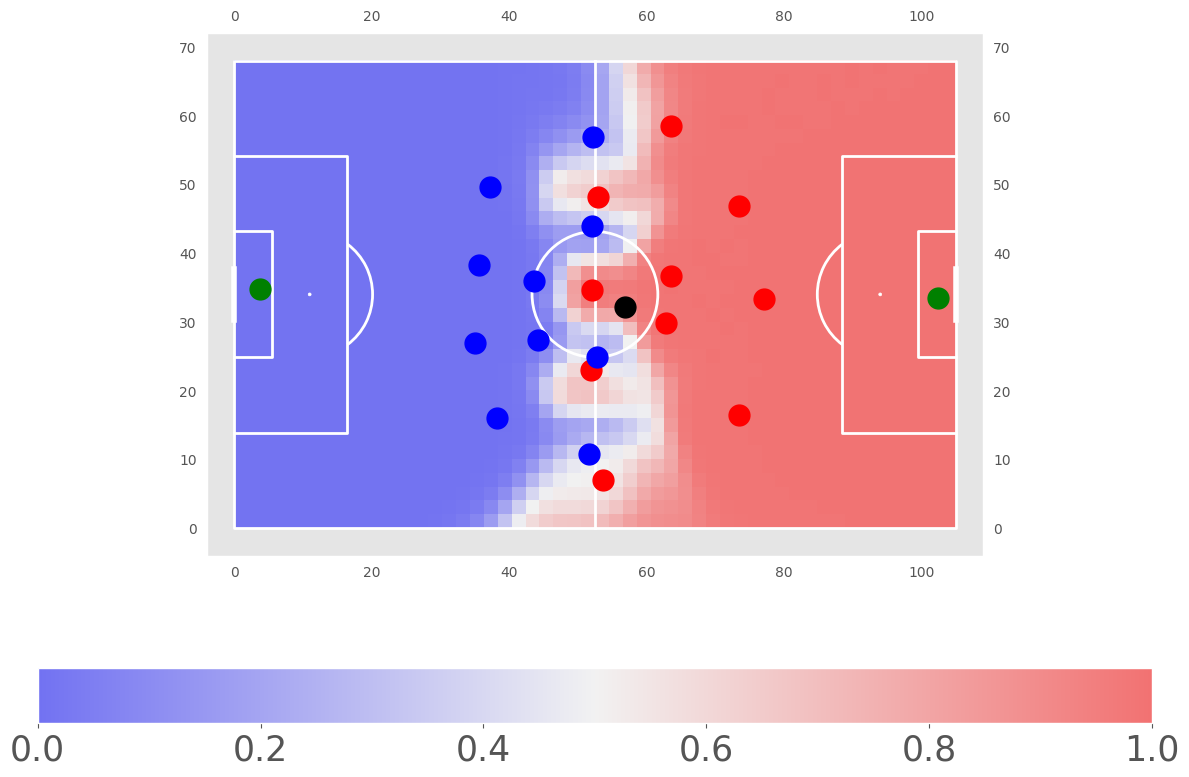

In [10]:
PPCFa, ax, event_df, xgrid, ygrid = calculate_model_pitch_control(melted_df, event_id=45)